In [ ]:
'''
Custom Training Mask RCNN

In [ ]:
'''
Steps: 
1. Download mrcnn folder and files from Mask RCNN Github
    - https://github.com/matterport/Mask_RCNN
2. Download mask_rcnn_coco.h5
    - https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
3. Upload the Anotated Image files(Dataset)
4. Save all the above files on Google drive
5. Change Directory to Main Folder of mask RCNN 

    import os
    os.chdir('/content/drive/MyDrive/MaskRCNN')

6. Use Specific version of tensroflow and Keras


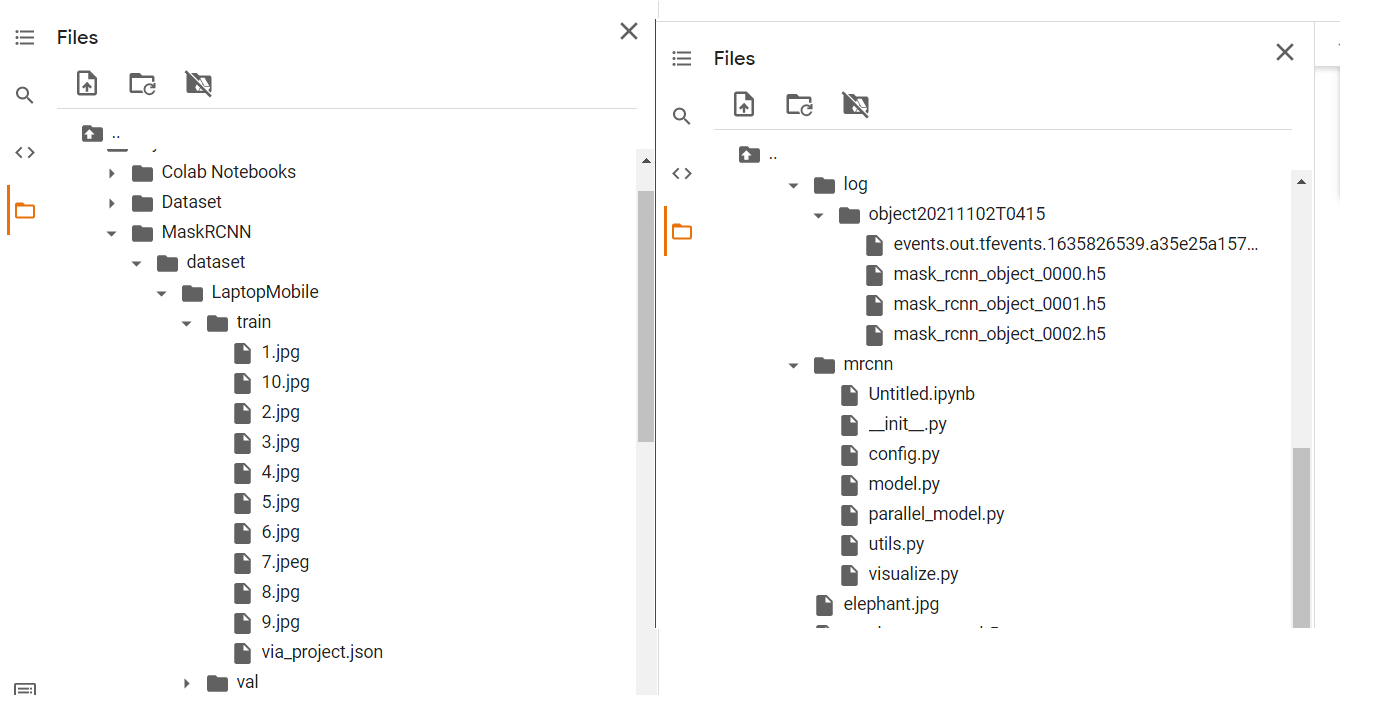

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os 
os.chdir('/content/drive/MyDrive/MaskRCNN')

In [2]:
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

     |████████████████████████████████| 92.6 MB 1.1 MB/s 
     |████████████████████████████████| 50 kB 4.6 MB/s 
     |████████████████████████████████| 367 kB 58.1 MB/s 
     |████████████████████████████████| 3.2 MB 26.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
from mrcnn.config import Config
from mrcnn import model as modellib, utils

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + phone,laptop and mobile

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "Laptop")
        self.add_class("object", 2, "Mobile")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

   
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open('/content/drive/MyDrive/MaskRCNN/dataset/LaptopMobile/train/via_project.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['Names'] for s in a['regions']]
            print("objects:",objects)
            #name_dict = {"laptop": 1,"tab": 2,"phone": 3}
            #name_dict = {"Horse": 1,"Man": 2} #,"xyz": 3}
            name_dict = {"Laptop": 1,"Mobile": 2} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/drive/MyDrive/MaskRCNN/dataset/LaptopMobile", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/drive/MyDrive/MaskRCNN/dataset/LaptopMobile", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,learning_rate=config.LEARNING_RATE,epochs=10,layers='heads')

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,model_dir="/content/drive/MyDrive/MaskRCNN/log")

model.load_weights("/content/drive/MyDrive/MaskRCNN/mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

train(model)

objects: ['Laptop']
numids [1]
objects: ['Laptop']
numids [1]
objects: ['Laptop']
numids [1]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop']
numids [1]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop']
numids [1]
objects: ['Laptop']
numids [1]
objects: ['Laptop']
numids [1]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop']
numids [1]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop', 'Mobile']
numids [1, 2]
objects: ['Laptop', 'Mobile']
numids [1, 2]
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/MaskRCNN/log/object20211101T1613/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 9/10 [==========================>...] - ETA: 144s - loss: 3.0624 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1677 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 1.5317 - mrcnn_mask_loss: 1.1168

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


10/10 [==============================] - 4279s - loss: 2.9298 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1601 - mrcnn_class_loss: 0.2223 - mrcnn_bbox_loss: 1.4929 - mrcnn_mask_loss: 1.0502 - val_loss: 1.5530 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.1546 - val_mrcnn_class_loss: 0.0662 - val_mrcnn_bbox_loss: 0.8951 - val_mrcnn_mask_loss: 0.4339
Epoch 2/10
10/10 [==============================] - 4113s - loss: 1.0766 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1297 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.5765 - mrcnn_mask_loss: 0.3126 - val_loss: 0.6945 - val_rpn_class_loss: 0.0028 - val_rpn_bbox_loss: 0.0945 - val_mrcnn_class_loss: 0.0462 - val_mrcnn_bbox_loss: 0.3496 - val_mrcnn_mask_loss: 0.2014
Epoch 3/10
10/10 [==============================] - 4071s - loss: 0.8014 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.4855 - mrcnn_mask_loss: 0.1779 - val_loss: 0.5619 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.074